# DuckDB Meetup

## Notebook for Fitbit data analysis with DuckDB
Expected to be run in a notebook, DuckDB’s Python client can be used [directly in Jupyter notebook](https://duckdb.org/docs/guides/python/jupyter)

In [1]:
import duckdb
import pandas as pd
import seaborn as sns

# Connect to DuckDB
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

# Configurations for jupysql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

A Jupyter cell can be used as a SQL cell by using the `%%sql` magic. Query results will be displayed as a Pandas DataFrame. This gives us the ability to alternate between SQL and Pandas

In [15]:
%%sql
SELECT extension_name, installed, loaded
FROM duckdb_extensions()
LIMIT 5;

,extension_name,installed,loaded
0,arrow,False,False
1,autocomplete,False,False
2,aws,False,False
3,azure,False,False
4,excel,False,False


## Querying Pandas Dataframes
DuckDB is able to find and query any dataframe stored as a variable in the Jupyter notebook.

In [16]:
movies_df = pd.DataFrame.from_dict({"Trilogy": [1, 2, 3],"Movie Name": ["A New Hope", "The Empire Strikes Back", "Return of the Jedi"]})

In [17]:
movies_df

,Trilogy,Movie Name
0,1,A New Hope
1,2,The Empire Strikes Back
2,3,Return of the Jedi


The dataframe can be specified just like any other table in the FROM clause.

In [18]:
%%sql
SELECT *
FROM movies_df;

,Trilogy,Movie Name
0,1,A New Hope
1,2,The Empire Strikes Back
2,3,Return of the Jedi


And you can create tables as if you were at the CLI

In [2]:
%%sql

CREATE OR REPLACE TABLE physical_activity
as
SELECT 
  startTime + INTERVAL 11 hours as activityTime
, activityName
, activityLevel
, averageHeartRate
, calories
, duration / 60000 as duration_minutes
, steps
, distance
, distanceUnit
, tcxLink
, source
FROM read_json('./exercise-*.json'
, columns={startTime: 'TIMESTAMP', activityName: 'VARCHAR',  activityLevel: 'JSON', averageHeartRate: 'INTEGER', calories: 'INTEGER', duration: 'INTEGER', steps: 'INTEGER', tcxLink: 'VARCHAR', distance: 'DOUBLE', distanceUnit: 'VARCHAR', source: 'JSON'}
, format='array'
, timestampformat='%m/%d/%y %H:%M:%S');

,Count
0,72


We can redirect the output of a query into a Python variable, with the `<<` assignment operator. 

In [20]:
%%sql
activity_df <<
  SELECT cast(time_bucket(interval '1 month', activityTime	) as DATE) as activity_day
  , activityName
  , sum(duration_minutes) as duration
  FROM physical_activity
  GROUP by 1, 2
  ORDER by 1;

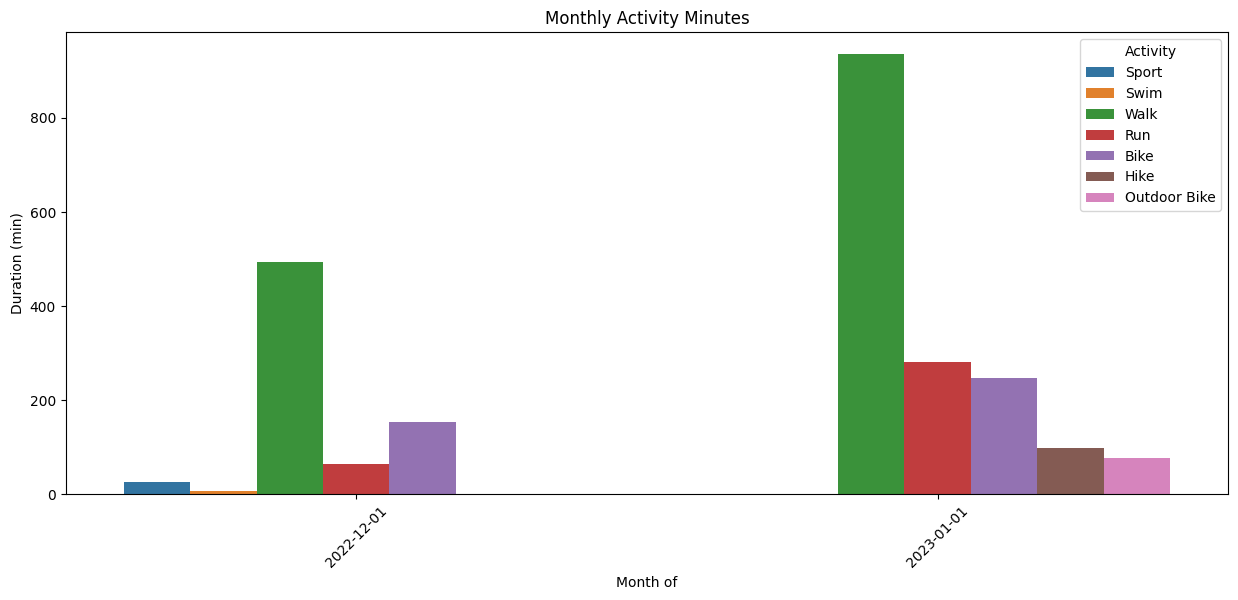

In [21]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)

myplot =sns.barplot(data=activity_df, x="activity_day", y="duration", hue="activityName")
myplot.set(xlabel='Month of', ylabel='Duration (min)', title='Monthly Activity Minutes')
plt.legend(loc="upper right", title='Activity') 
plt.show()


We'll now define a named query `--save short_trips`, but not execute it `--no-execute`. This tells JupySQL to store the query, but not  execute it yet.

In [23]:
%%sql --save short_trips --no-execute
SELECT *
FROM 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet'
WHERE trip_distance < 6.3

Skipping execution...

With the `short-trips` query defined previously we can plot a subset of the data. This technique is useful to plot massive datasets directly through the engine  - avoiding both the download of the entire file and avoiding loading all of it into Pandas in memory.

<Axes: title={'center': "'trip_distance' from 'short_trips'"}, xlabel='trip_distance', ylabel='Count'>

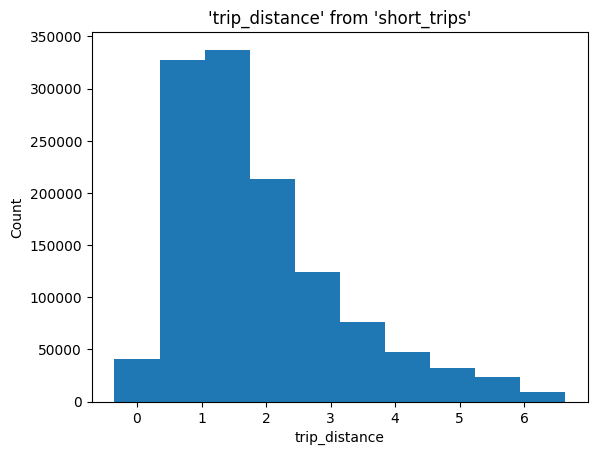

In [24]:
%sqlplot histogram --table short_trips --column trip_distance --bins 10 --with short_trips